**DATA**
:The EEG device used in the experiment is the Emotiv Epoc X 14 channel headset

**Data Acquisition**
:several students with varying levels of education (High school, Middle school, Undergraduate) were invited to watch an online lecture and recorded their EEG data and brain waves during the lecture. Experiment began by asking them several questions to understand their knowledge base and picked several videos that they would be able to understand and several videos that they wouldn't be able to understand. Then recorded their EEG data, Brain waves, and added a binary variable that indicated whether the student understood the lecture or not. (1 = Understood the lecture | 0 = Did not understand the lecture). All of recordings were then appended to a single dataset (EEG data.csv). 

**Experiment**
The data contains eeg signals from 14 electriodes. In this experiment, eeg signal is split in to chunks of 2 seconds and then alpha beta, theta and delta components from all these electrodes are used as features to make a classification model.
The classification models include, SVM, Logestic regresssion model, two of ensomble model (Random forrest and XG boost) and an Artificial neural network model.

**Among all the classifiers SVM outperformed all others with highest F1 score of 0.93**

In [ ]:
pip install eli5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import zipfile
import pandas as pd
import seaborn
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import f1_score,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
import eli5
from sklearn.model_selection import train_test_split
from keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import tensorflow
warnings.filterwarnings("ignore")

#https://www.kaggle.com/datasets/madyanomar/eeg-data-distance-learning-environment?resource=download

Mounted at /content/drive


In [ ]:
donot run
zip_src = "/content/drive/MyDrive/EEG/archive.zip"
zip_des = "/content/drive/MyDrive/EEG/data"

with zipfile.ZipFile(zip_src, 'r') as zip_ref:
    zip_ref.extractall(zip_des)

# **Main**

In [ ]:
def get_components(data):
  '''The Function calculates brain wave components
     for the given chunk of eeg signal
     Input parameters :
                      data  : Type Pandas Data Frame
     Returns          :
                       eeg_band_fft :Type dictionary
                                     Dictionary with keys as brain
                                     wave components and values as
                                     the component value '''
  fs       = 128 # Sampling rate (128 HZ) 
  # Get real amplitudes of FFT components 
  fft_vals = np.absolute(np.fft.rfft(data))

  # Get frequencies for amplitudes in Hz
  fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

  # Define EEG bands
  eeg_bands = {'Delta': (0.5, 3),
              'Theta': (4, 7),
              'Alpha': (8, 13),
              'Beta': (14, 30)}

  # Take average of the fft amplitude for each EEG band
  eeg_band_fft = dict()
  for band in eeg_bands:  
      freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                        (fft_freq <= eeg_bands[band][1]))[0]
      eeg_band_fft[band] = np.mean(np.square(fft_vals[freq_ix]))

  return eeg_band_fft

def generate_features(data_df,required_columns):
  '''The function preprocess the incoming raw eeg signal
    preprocessing includes clipping the raw signal to chunks of 
    predefined length and calls get_components function to extract 
    brain wave components
    Input Parameters:
                    data_df         : Type Pandas Dataframe
                                      Raw eeg signal data
                    required_columns: Type List
                                      Columns to keep in the 
                                      processed data frame
    Returns         :
                    processed_df    : Type pandas Data Frame
                                      Preprocessed data frame with relevent 
                                      features'''

  processed_df       = pd.DataFrame()  #output data frame to hold features
  grp                = list(data_df.groupby(by = ['subject_id','video_id']).groups.keys())
  n                  = 2
  electrode          = selected_columns[0][4:]

  for subject_key,video_key in grp:
    sample           = data_df[(data_df.subject_id == subject_key) &
                     (data_df.video_id == video_key)][required_columns]
    start            = 0
    for i in range(0,len(sample),128*n):
      if i !=0:
        chunk        = sample[start:i]
        eeg_band_fft = get_components(chunk[required_columns[0]])
        label        = chunk.subject_understood.values[0]
        subject      = chunk.subject_id.values[0]
        video        = chunk.video_id.values[0]

        processed_df = processed_df.append({'subject_id':subject,'video_id':video,
                                    'Delta_' + electrode:eeg_band_fft['Delta'],
                                    'Theta_' + electrode:eeg_band_fft['Theta'],
                                    'Alpha_' + electrode:eeg_band_fft['Alpha'],
                                    'Beta_' + electrode:eeg_band_fft['Beta'],
                                    'label':label, 'slice_index':i},ignore_index=True)
        #print(eeg_band_fft.values())
        start = i
  return processed_df


def visualize_features(data,electrode):
  '''The function aids to visualize the feature space in
     low dimension, by applying PCA
     
     Input Parameters:
                      data     : Type pandas Data frame
                                 Data frame containing processed features
                      electrode : Type list of string
                                 List of electrodes to aid visualization'''

  hue       = data['label']                          
  data      = data.drop(columns = ['subject_id','video_id','label','slice_index'])
  features  = [item + ele for item in ['Delta_','Theta_', 'Alpha_','Beta_'] for ele in electrode]
  
  data      = data[features]
  pca       = PCA(n_components=2)
  x_new     = pca.fit_transform(data)


  seaborn.scatterplot(x_new[:,0], x_new[:,1], hue = hue).set_title('Features from '+ ' '.join(electrode))
  plt.show()

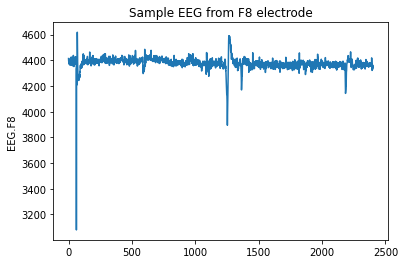

Processing signals from EEG.AF3
Processing signals from EEG.F7
Processing signals from EEG.F3
Processing signals from EEG.FC5
Processing signals from EEG.FC6
Processing signals from EEG.F4
Processing signals from EEG.F8
Processing signals from EEG.AF4


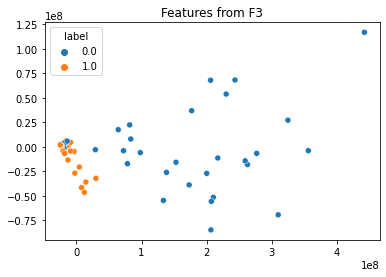

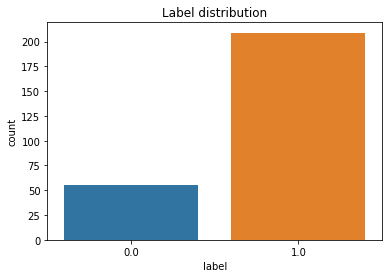

In [ ]:
data_path        = "/content/drive/MyDrive/EEG/data/EEG_data.csv"
data_df          = pd.read_csv(data_path)

#plotting a sample eeg signal
sample           = data_df[(data_df.subject_id ==0 ) & (data_df.video_id == 0)]
seaborn.lineplot(sample.index,sample['EEG.F8']).set_title('Sample EEG from F8 electrode')
plt.show()

combined_df      = pd.DataFrame() # data frame to hold all the selected electrode eeg signals

#list of electrode signals to be used
electrode_list   = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5','EEG.FC6','EEG.F4', 'EEG.F8', 'EEG.AF4']


#process each electrode signal seperatly
for electrode in electrode_list:
  print(f"Processing signals from {electrode}")
  selected_columns = [electrode,'subject_understood','subject_id','video_id']
  data             = generate_features(data_df,selected_columns)   #generate the required features

  if len(combined_df) == 0:
    combined_df    = data
  else:
      combined_df  = pd.merge(combined_df,data,on = ['subject_id','video_id','label','slice_index'],how = 'inner')

electrode = ['F3']
visualize_features(combined_df,electrode)
seaborn.countplot(combined_df.label).set_title('Label distribution')
plt.show()

# **Classification**
1. Logestic regression
2. SVM
3. Random forrest
4. Xgboost
5. ANN

# **Logestic regression**


In [ ]:
warnings.filterwarnings("ignore")
penality_list = ['l1','l2','elasticnet']
solver_list   = ['newton-cg','lbfgs','liblinear','sag','saga']

#a scorer function to be used in k cross validation (since the data is imbalanced, f1 score can be used as a metric)
score_function = make_scorer(f1_score)

score_df    = pd.DataFrame() # A data framee to hold all the hyper parameter and resultant score

#Removing majority samples as the algorithom donot support internal balancing
temp = combined_df[combined_df.label==1].sample(frac = 0.65)
combined_df_b = combined_df[~combined_df.index.isin(temp.index)]

#Extract the data to train
X           = combined_df_b.drop(columns = ['subject_id','video_id','label','slice_index'])
y           = combined_df_b['label']

#Standarization of data

X_norm      = pd.DataFrame(data = StandardScaler().fit_transform(X), columns = list(X.columns))
#X          = MinMaxScaler().fit_transform(X)

#Grid search 
for pnlty in penality_list:
  for sol in solver_list:
    try:                #some solvers are incompatable with certain penality
      clf    = LogisticRegression(penalty=pnlty, solver = sol,class_weight = 'balanced', multi_class = 'ovr')
      scores = cross_val_score(clf, X_norm, y, cv=5, scoring=score_function)         #scores returns the f1_score for all the folds
      #print(kernel, g, c, np.mean(scores))
      score_df = score_df.append({'penality':pnlty,'solver':sol,'Mean_score':np.mean(scores)}, ignore_index = True)
    except :
      pass

#find the best model post grid search
score_df = score_df.fillna(0)
row = score_df[score_df.Mean_score == max(score_df.Mean_score)]
print(f"The Best logestic regression model with solver :{row['solver'].values[0]}, penality : {row['penality'].values[0]}, and  F1 score : {row['Mean_score'].values[0]}")


The Best logestic regression model with solver :saga, penality : l1, and  F1 score : 0.8558720466294278


# **SVM**

In [ ]:
#to apply a grid search to find the apt parameters
gamma_list  = ['scale', 'auto',0.001,0.01,0.1,1,10,100,1000] 
c_list      = [0.001,0.01,0.1,1,10,100,1000] 
kernel_list = ['poly','rbf']

#a scorer function to be used in k cross validation (since the data is imbalanced, f1 score can be used as a metric)
score_function = make_scorer(f1_score)

score_df    = pd.DataFrame() # A data framee to hold all the hyper parameter and resultant score

#Extract the data to train
X           = combined_df.drop(columns = ['subject_id','video_id','label','slice_index'])
y           = combined_df['label']

#Standarization of data
X_norm      = StandardScaler().fit_transform(X)
#X          = MinMaxScaler().fit_transform(X)

#Grid search 
for kernel in kernel_list:
  for g in gamma_list:
    for c in c_list:
      clf    = SVC(gamma = g,kernel = kernel, class_weight = 'balanced',C = c)
      scores = cross_val_score(clf, X_norm, y, cv=5, scoring=score_function)         #scores returns the f1_score for all the folds
      #print(kernel, g, c, np.mean(scores))
      score_df = score_df.append({'kernel':kernel,'Gamma':g,'C':c,'Mean_score':np.mean(scores)}, ignore_index = True)

#find the best model post grid search
row = score_df[score_df.Mean_score == max(score_df.Mean_score)]
print(f"The Best SVM model found at {row['kernel'].values[0]},with  Gamma : {row['Gamma'].values[0]}, C : {row['C'].values[0]} and  F1 score : {row['Mean_score'].values[0]}")

The Best SVM model found at rbf,with  Gamma : 0.001, C : 1.0 and  F1 score : 0.9373654182672894


# **RANDOM FORREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
estimator_list  = [10,20, 50,100,150,200,250,300,350] 
depth_list      = [3, 5, 7, 9, 15, 20, 25] 

#a scorer function to be used in k cross validation (since the data is imbalanced, f1 score can be used as a metric)
score_function = make_scorer(f1_score)

score_df    = pd.DataFrame() # A data framee to hold all the hyper parameter and resultant score

#Extract the data to train
X           = combined_df.drop(columns = ['subject_id','video_id','label','slice_index'])
y           = combined_df['label']

#Standarization of data
X_norm      = pd.DataFrame(data = StandardScaler().fit_transform(X), columns = list(X.columns))
#X          = MinMaxScaler().fit_transform(X)

#Grid search 
for n_est in estimator_list:
  for depth in depth_list:
    clf    = RandomForestClassifier(max_depth=depth, random_state=2,n_estimators=n_est, class_weight = 'balanced')
    scores = cross_val_score(clf, X_norm, y, cv=5, scoring=score_function)         #scores returns the f1_score for all the folds
    #print(kernel, g, c, np.mean(scores))
    score_df = score_df.append({'num_estimator':n_est,'depth':depth,'Mean_score':np.mean(scores)}, ignore_index = True)

#find the best model post grid search
row = score_df[score_df.Mean_score == max(score_df.Mean_score)]
print(f"The Best Random forrest model found at number of estimatores :{row['num_estimator'].values[0]},with  depth : {row['depth'].values[0]}, and  F1 score : {row['Mean_score'].values[0]}")

The Best Random forrest model found at number of estimatores :150.0,with  depth : 5.0, and  F1 score : 0.8903934428742613


# **XG boost classifier**

In [ ]:

estimator_list  = [10,20, 50,100,150,200,250,300,350] 
depth_list      = [3, 5, 7, 9, 15, 20, 25] 

#a scorer function to be used in k cross validation (since the data is imbalanced, f1 score can be used as a metric)
score_function = make_scorer(f1_score)

score_df    = pd.DataFrame() # A data framee to hold all the hyper parameter and resultant score

#Removing majority samples as the algorithom donot support internal balancing
temp = combined_df[combined_df.label==1].sample(frac = 0.65)
combined_df_b = combined_df[~combined_df.index.isin(temp.index)]

#Extract the data to train
X           = combined_df_b.drop(columns = ['subject_id','video_id','label','slice_index'])
y           = combined_df_b['label']

#Standarization of dat
X_norm      = pd.DataFrame(data = StandardScaler().fit_transform(X), columns = list(X.columns))
#X          = MinMaxScaler().fit_transform(X)

#Grid search 
for n_est in estimator_list:
  for depth in depth_list:
    clf    = GradientBoostingClassifier(max_depth=depth, random_state=2,n_estimators=n_est)
    scores = cross_val_score(clf, X_norm, y, cv=5, scoring=score_function)         #scores returns the f1_score for all the folds
    #print(kernel, g, c, np.mean(scores))
    score_df = score_df.append({'num_estimator':n_est,'depth':depth,'Mean_score':np.mean(scores)}, ignore_index = True)

#find the best model post grid search
row = score_df[score_df.Mean_score == max(score_df.Mean_score)]
print(f"The Best XG boost model found at number of estimatores :{row['num_estimator'].values[0]},with  depth : {row['depth'].values[0]}, and  F1 score : {row['Mean_score'].values[0]}")


The Best XG boost model found at number of estimatores :100.0,with  depth : 3.0, and  F1 score : 0.8221357063403782


# **Artificial Neural Network**

In [ ]:

def recall_m(y_true, y_pred):
  '''This function can be used while compiling any sequential or functional model
  to include the recall value as one of the metric
  Inputs:
        y_true : tensor object
        y_pred : tensor object
  Returns:
        calculated recall value
  '''
  true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
  possible_positives = K.sum (K.round(K.clip(y_true, 0, 1)))
  recall = true_positives/(possible_positives + K.epsilon())
  return recall

def precision_m(y_true, y_pred):
  '''This function can be used while compiling any sequential or functional model
  to include the precision value as one of the metric
  Inputs:
        y_true : tensor object
        y_pred : tensor object
  Returns:
        calculated precision value
  '''
  true_positives = K.sum(K.round(K.clip (y_true* y_pred, 0, 1)))
  predicted_positives = K.sum (K. round (K.clip (y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision


def f1_m(y_true, y_pred):
  '''This function can be used while compiling any sequential or functional model
  to include the f1 score value as one of the metric
  Inputs:
        y_true : tensor object
        y_pred : tensor object
  Returns:
        calculated f1 score value
  '''
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

def plot_graphs(history, string):
  '''This function is used to plot traing history of any one metric
  Inputs:
        history : model object
        string  : metric name as string 
  Returns:
        calculated precision value'''
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel (string)
  plt.show()

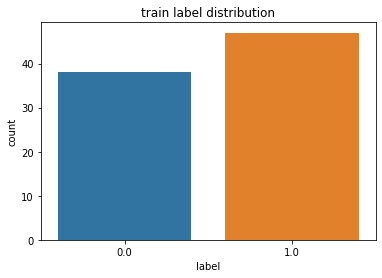

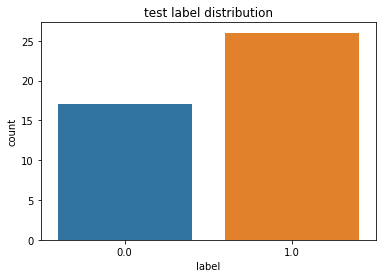

In [ ]:
#Removing majority samples manually
temp = combined_df[combined_df.label==1].sample(frac = 0.65)
combined_df_b = combined_df[~combined_df.index.isin(temp.index)]

X           = combined_df_b.drop(columns = ['subject_id','video_id','label','slice_index'])
y           = combined_df_b['label']

#Normalize the data
X          = pd.DataFrame(data = StandardScaler().fit_transform(X), columns = list(X.columns))

#spliting the data to test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
seaborn.countplot(y_train).set_title('train label distribution')
plt.show()
seaborn.countplot(y_test).set_title('test label distribution')
plt.show()

In [ ]:
#creating dense network
tensorflow.random.set_seed(2)

model = Sequential()
model.add(Dense(32,input_shape=(32,), activation = 'relu'))
model.add(Dense(16,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(optimizer = 'adam',loss = 'binary_crossentropy',
              metrics=['accuracy',precision_m, recall_m,f1_m])

model.summary()
history =  model.fit(X_train, y_train, batch_size = 64, epochs = 25, verbose = 1, shuffle = True)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2/2 [==============================] - 3s 8ms/step - loss: 0.7266 - accuracy: 0.4235 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 7ms/step - loss: 0.6852 - accuracy: 0.4235 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - f1_m: 0

# **Analysis**
**The Best logestic regression model with solver :saga, penality : l1, and  F1 score : 0.85**

**The Best SVM model found at rbf,with  Gamma : 0.001, C : 1.0 and  F1 score : 0.94**

**The Best Random forrest model found at number of estimatores :150.0,with  depth : 5.0, and  F1 score : 0.89**

**The Best XG boost model found at number of estimatores :100.0,with  depth : 3.0, and  F1 score : 0.82**

**For ANN, changind the number of nodes didnot bring about any improvements. The ANN model generated at F1 score, 0.82**

In [ ]:
#ANN model prediction
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1,0)

print(classification_report(y_test,y_pred))
print("Confusion matrix \n",confusion_matrix(y_test,y_pred))
print("\nF1 score :",f1_score(y_test,y_pred))

2/2 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         0.0       0.82      0.53      0.64        17
         1.0       0.75      0.92      0.83        26

    accuracy                           0.77        43
   macro avg       0.78      0.73      0.74        43
weighted avg       0.78      0.77      0.75        43

Confusion matrix 
 [[ 9  8]
 [ 2 24]]

F1 score : 0.8275862068965517


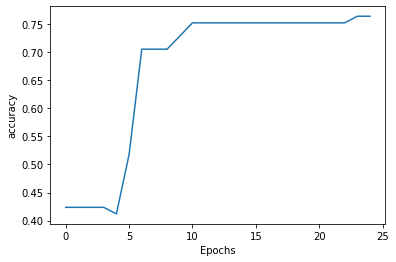

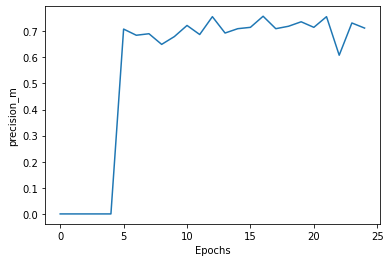

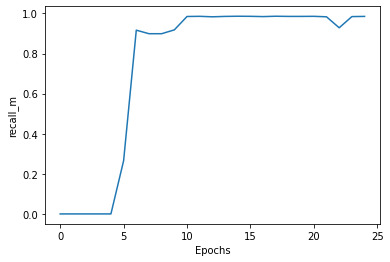

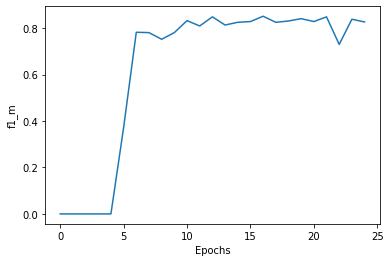

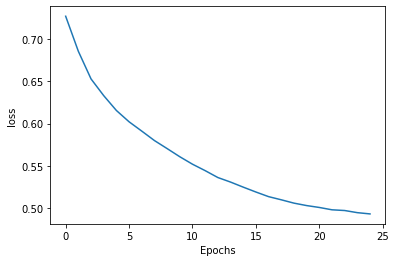

In [ ]:
#plot the ANN training history
plot_graphs(history, "accuracy")
plot_graphs(history, "precision_m")
plot_graphs(history, "recall_m")
plot_graphs(history, "f1_m")
plot_graphs(history, "loss")

**Permutation feature importance for Logestic Regression model, Random forrest and Xgboost**

In [ ]:
logestic_regression_model = LogisticRegression(penalty='l1', solver = 'saga',class_weight = 'balanced', multi_class = 'ovr').fit(X_norm,y)
eli5.show_weights(logestic_regression_model, feature_names=list(X_norm.columns), top = len(X_norm))

Weight?,Feature
+0.355,Theta_F8
+0.258,Delta_F8
+0.195,Delta_AF4
+0.110,Delta_FC6
+0.059,Delta_F7
+0.003,Alpha_F8
-0.060,Beta_AF3
-0.061,Theta_F3
-0.102,Theta_F4
-0.115,Theta_FC5


In [ ]:
randomforrest_model = RandomForestClassifier(max_depth=5, random_state=2,n_estimators=150, class_weight = 'balanced').fit(X_norm,y)
eli5.show_weights(randomforrest_model, feature_names=list(X_norm.columns), top = len(X_norm))

Weight,Feature
0.0824 ± 0.2329,Beta_FC6
0.0676 ± 0.2587,Delta_F3
0.0489 ± 0.2089,Alpha_F3
0.0484 ± 0.2274,Alpha_AF3
0.0414 ± 0.1933,Beta_F8
0.0409 ± 0.1714,Beta_F7
0.0403 ± 0.1699,Delta_F8
0.0375 ± 0.1684,Beta_AF3
0.0370 ± 0.1476,Alpha_FC6
0.0367 ± 0.1882,Alpha_F4


In [ ]:
gradientboosting_model = GradientBoostingClassifier(max_depth=3, random_state=2,n_estimators=100).fit(X_norm,y)
eli5.show_weights(gradientboosting_model, feature_names=list(X_norm.columns), top = len(X_norm))

Weight,Feature
0.2368 ± 0.3487,Delta_F3
0.1925 ± 0.2478,Beta_FC6
0.0726 ± 0.3149,Alpha_F4
0.0606 ± 0.1851,Beta_AF4
0.0572 ± 0.2415,Alpha_AF3
0.0465 ± 0.1350,Alpha_F3
0.0356 ± 0.2073,Theta_FC6
0.0338 ± 0.1797,Theta_AF3
0.0330 ± 0.1618,Delta_F4
0.0282 ± 0.2017,Delta_F8
